In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, compute_statistics, NormalizeCube, NormalizeProfile

from combined import CombinedModel

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
# Create an instance of the dataset to compute statistics
dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_all')
channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

# Define the custom transformations using the computed statistics
cube_transform = NormalizeCube(mean=channel_means_cube.tolist(), std=channel_stds_cube.tolist())
profile_transform = NormalizeProfile(mean=channel_means_profile.tolist(), std=channel_stds_profile.tolist())

# Apply the custom transforms to the datasets
train_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_train', cube_transform=cube_transform, profile_transform=profile_transform)
val_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_validation', cube_transform=cube_transform, profile_transform=profile_transform)
test_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_test', cube_transform=cube_transform, profile_transform=profile_transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Test the loader
for cube, profile, label in train_loader:
    print("Cube shape:", cube.shape)
    print("Profile shape:", profile.shape)
    print("Label:", label)
    break

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 25, 'Streptococcus_agalactiae': 26, 'Staphylococcus_saprophiticus': 27, 'Bacteroides_fragilis': 28, 'Neisseria_gonorrhoeae': 29, 'Veionella': 30, 'Proteus': 31, 'Candida_albicans': 32}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [3]:
model = CombinedModel(num_classes=len(dataset.label_map)).to(device)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

In [5]:
# Function to check gradients
def check_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f'{name} gradient: {param.grad.abs().mean().item()}')
            
check_gradients(model)

In [6]:


# Initialize lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_change_epochs = []

# Number of epochs
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for cube, profile, label in train_loader:
        cube, profile, label = cube.to(device), profile.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(cube, profile)
        loss = criterion(output, label)
        loss.backward()
        
        # Check gradients
       # check_gradients(model)
        
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(output.data, 1)
        total_train += label.size(0)
        correct_train += (predicted == label).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for cube, profile, label in val_loader:
            cube, profile, label = cube.to(device), profile.to(device), label.to(device)

            output = model(cube, profile)
            loss = criterion(output, label)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val += label.size(0)
            correct_val += (predicted == label).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss and track LR changes
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        lr_change_epochs.append(epoch)
        print(f"Learning rate reduced from {old_lr} to {new_lr}")


Epoch [1/200], Loss: 4.3287, Training Accuracy: 25.19%
Validation Loss: 1.8972, Validation Accuracy: 69.74%
Epoch [2/200], Loss: 3.1052, Training Accuracy: 51.31%
Validation Loss: 1.8116, Validation Accuracy: 67.11%
Epoch [3/200], Loss: 2.4486, Training Accuracy: 56.72%
Validation Loss: 1.1781, Validation Accuracy: 77.63%
Epoch [4/200], Loss: 2.0435, Training Accuracy: 61.75%
Validation Loss: 0.9924, Validation Accuracy: 81.58%
Epoch [5/200], Loss: 2.2286, Training Accuracy: 63.25%
Validation Loss: 0.9525, Validation Accuracy: 78.95%
Epoch [6/200], Loss: 1.8792, Training Accuracy: 68.66%
Validation Loss: 1.1924, Validation Accuracy: 81.58%
Epoch [7/200], Loss: 2.0655, Training Accuracy: 65.11%
Validation Loss: 1.8906, Validation Accuracy: 76.32%
Epoch [8/200], Loss: 1.5935, Training Accuracy: 70.90%
Validation Loss: 1.5150, Validation Accuracy: 76.32%
Epoch [9/200], Loss: 1.8769, Training Accuracy: 70.15%
Validation Loss: 1.0213, Validation Accuracy: 76.32%
Epoch [10/200], Loss: 1.4768

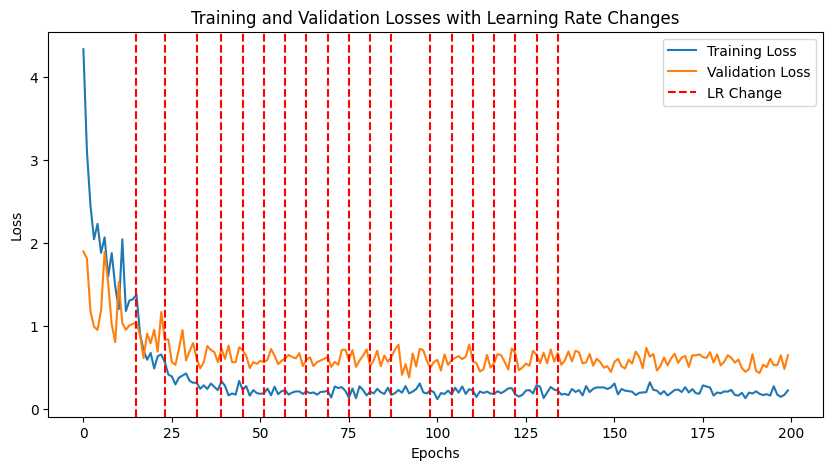

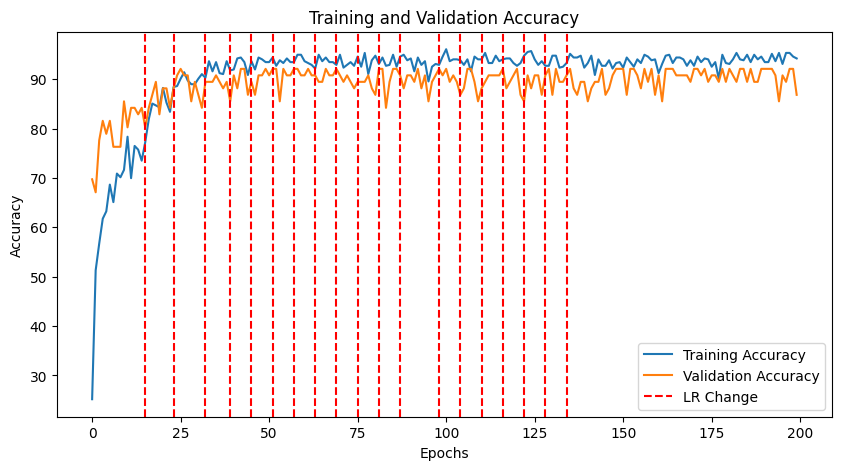

In [7]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [8]:
# Testing phase
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for cube, profile, label in test_loader:
        cube, profile, label = cube.to(device), profile.to(device), label.to(device)

        output = model(cube, profile)
        loss = criterion(output, label)
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_test += label.size(0)
        correct_test += (predicted == label).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.7327, Test Accuracy: 90.91%


In [9]:
# Function to test an individual sample from the test split
def test_individual_test_sample(sample_idx):
    # Load a specific sample from the test dataset
    cube, profile, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube.to(device).unsqueeze(0)  # Add batch dimension
    profile = profile.to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube, profile)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Print the results
    print(f"Predicted class: {predicted_class.item()}, Probability: {probabilities[0][predicted_class.item()]:.4f}")
    print(f"True label: {label.item()}")

# Test an individual sample from the test split (e.g., sample index 0)
test_individual_test_sample(4)


Predicted class: 2, Probability: 0.9999
True label: 2
